Using 
- sdpa 
- optimizer
- compile 
- more data
- MixedPrecision()
- lr_sched
- Double layer norm
- Using a custom tokenizer.

# Tiny Stories Hackathon
> From Cluster of stars study group

## Data

### Dataset 

In [ ]:
from datasets import load_dataset
import tiktoken
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor, BoolTensor

from minai import *

Grab tiny stories data from hugging face.

In [ ]:
ds = load_dataset('roneneldan/TinyStories')
trn = ds['train']
val = ds['validation']
trn

Dataset({
    features: ['text'],
    num_rows: 2119719
})

In [ ]:
val

Dataset({
    features: ['text'],
    num_rows: 21990
})

In [ ]:
from minbpe import RegexTokenizer
from fastcore.all import *

In [ ]:
path = Path.home()/'git/minai/TinyStories_All_data'

In [ ]:
tokenizer = RegexTokenizer()
# tokenizer.train(txt_raw, vocab_size=3000)

tokenizer.load((path/"tok3k_regex.model").name) # loads the model back from disk
tokenizer.encode("hello world") # string -> tokens

[257, 2365, 1597]

In [ ]:
txt = trn[0]['text']
txt

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'

In [ ]:
def txt_to_toks(txt, toker): return toker.encode(txt)

In [ ]:
def toks_to_txt(toks, toker): return toker.decode(toks)

In [ ]:
2119719 // 20

105985

In [ ]:
separator="\n\n\n"
ctx_len = 1024
num_txts = 2119719 // 20

trn_txts = separator.join([trn[i]['text'] for i in range(num_txts)])
trn_txts[:1000]

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.\n\n\nOnce upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leaves that we

We create a dataset.

In [ ]:
# Code from llm from scratch
class TinyDataset(Dataset):
    def __init__(self, txt, tokenizer, ctx_len):
        self.inp = []
        self.targ = []
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        for i in range(0, len(token_ids) - ctx_len, ctx_len):
            inp_chunk = token_ids[i:i + ctx_len]
            targ_chunk = token_ids[i + 1: i + ctx_len + 1]
            self.inp.append(torch.tensor(inp_chunk))
            self.targ.append(torch.tensor(targ_chunk))

    def __len__(self): return len(self.inp)

    def __getitem__(self, idx): return self.inp[idx], self.targ[idx]

In [ ]:
len(trn_txts)

93888689

In [ ]:
trn_ds = TinyDataset(trn_txts, tokenizer, ctx_len,)
trn_ds[0]

(tensor([516, 327,  44,  ..., 265, 325, 328]),
 tensor([327,  44, 258,  ..., 325, 328, 261]))

In [ ]:
## Validation set
num_val_txts = 2199
val_txts = separator.join([val[i]['text'] for i in range(num_val_txts)])
val_ds = TinyDataset(val_txts, tokenizer, ctx_len)

### DataLoader

In [ ]:
bs = 8

trn_dl, val_dl = get_dls(trn_ds, val_ds, bs, drop_last=True, pin_memory=True)
dls = DataLoaders(trn_dl, val_dl)
xb,yb = next(iter(trn_dl))
xb.shape,yb.shape

(torch.Size([8, 1024]), torch.Size([8, 1024]))

## Model

### SDPA

In [ ]:
import torch.nn as nn

Here's the `MultiHeadAttention` with Causal attention.

In [ ]:
class SDPACausalAttentionBlock(nn.Module):
    """
    Attention block implementing multi-head causal (masked) attention using
    PyTorch's scaled_dot_product_attention (SDPA).
    """

    def __init__(
        self,
        hidden_dim: int,
        num_heads: int,
        dropout: float = 0.0,
    ):
        """
        Initialize the causal attention block with SDPA implementation.
        """
        super().__init__()
        if hidden_dim % num_heads != 0: raise Exception("hidden_dim not divisible by num_heads")
        self.head_dim = hidden_dim // num_heads
        self.num_heads = num_heads
        self.Wq, self.Wk, self.Wv = nn.Linear(hidden_dim, hidden_dim), nn.Linear(hidden_dim, hidden_dim), nn.Linear(hidden_dim, hidden_dim)
        self.Wo = nn.Linear(hidden_dim, hidden_dim)
#         self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass.
        """
        batch_size, seq_len, hidden_dim = x.shape
        q,k,v = self.Wq(x), self.Wk(x), self.Wv(x) # [batch_size, seq_len, d_out]

        sdpa_ctx = torch.nn.functional.scaled_dot_product_attention(
            q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2), 
            k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2), 
            v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2), 
            dropout_p=0.0, is_causal=True, scale=None)
        sdpa_ctx = sdpa_ctx.transpose(1,2).view(batch_size, seq_len, -1)
        return self.Wo(sdpa_ctx)
#         return self.dropout(self.Wo(sdpa_ctx))
#         return sdpa_ctx

### FeedForward

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, in_dim, hidden_dim, act=nn.ReLU()):
        super().__init__()
        self.l1 = nn.Linear(in_dim, hidden_dim, bias=False)
        self.act = act
        self.l2 = nn.Linear(hidden_dim, in_dim, bias=False)
    
    def forward(self, x):
        return self.l2(self.act(self.l1(x)))

In [ ]:
class GLU(nn.Module):
    """
    The Gated Linear Unit has two parallel linear transforms: one for the gate and one for the value.
    Apply the activation only to the gate, then multiply elementwise with the value, followed by a
    final linear projection and optional dropout.
    """
    def __init__(
        self,
        hidden_dim: int,
        intermediate_dim: int,
        act: nn.Module = nn.GELU,
        dropout: float = 0.0,
    ):
        """
        Initialize a GLU.

        Args:
            hidden_dim: Dimension of the input and output features
            intermediate_dim: Dimension of each intermediate branch
                              Often set to 2/3 * 4 * hidden_dim to maintain similar parameter
                              count to a standard MLP with 4x expansion
            activation: Activation function to use, defaults to GELU
            dropout: Output dropout probability (0.0 means no dropout)
        """
        super().__init__()
        self.Wv = nn.Linear(hidden_dim, intermediate_dim)
        self.Wg = nn.Linear(hidden_dim, intermediate_dim)
        self.act = act
        self.Wo = nn.Linear(intermediate_dim, hidden_dim)
        self.do = nn.Dropout(dropout)

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass.

        Args:
            x: Input tensor of shape [batch_size, seq_len, hidden_dim] or [total_seq_len, hidden_dim]

        Returns:
            Tensor of shape [batch_size, seq_len, hidden_dim] or [total_seq_len, hidden_dim]
        """
        gate = self.act(self.Wg(x))
        val = self.Wv(x)
        out = self.Wo(gate * val)
        return self.do(out)

### Transformer Block

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_dim, ctx_len, n_head, drop_out=0, ff_mult=4, qkv_bias=False, act=nn.ReLU()):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_dim)
        self.ln2 = nn.LayerNorm(emb_dim)
        self.ln3 = nn.LayerNorm(emb_dim)
        self.ln4 = nn.LayerNorm(emb_dim)
        self.mha = SDPACausalAttentionBlock(hidden_dim=emb_dim, num_heads=n_head, dropout=drop_out)
        self.ff = GLU(emb_dim, int(emb_dim*ff_mult), act=act)
    
    def forward(self, x):
        skip1 = x
        x = self.ln1(x)
        x = self.mha(x)
        x = self.ln2(x)
        x = x + skip1
        
        skip2 = x
        x = self.ln3(x)
        x = self.ff(x)
        x = self.ln4(x)
        x = x + skip2
        return x

### GPT model

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg['vocab_sz'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['vocab_sz'], cfg['emb_dim'])
        self.do = nn.Dropout(cfg['drop_out'])
        self.tb = nn.Sequential(
            *[TransformerBlock(cfg['emb_dim'], cfg['ctx_len'], cfg['n_head'], cfg['drop_out_tb'],
                              cfg['ff_mult'], cfg['qkv_bias'], cfg['act']) for _ in range(cfg['n_tb'])])
        self.final_ln = nn.LayerNorm(cfg['emb_dim'])
        self.final_l  = nn.Linear(cfg['emb_dim'], cfg['vocab_sz'])
    
    def forward(self, x):
        bs, seq_len = x.shape
        tok = self.token_emb(x)
        pos = self.pos_emb(torch.arange(seq_len, device=x.device))
        x = self.do(tok + pos)
        x = self.tb(x)
        x = self.final_ln(x)
        x = self.final_l(x)
        return x

In [ ]:
def get_total_params(model): return sum(p.numel() for p in model.parameters())

In [ ]:
def get_total_memory(model):
    total_params = get_total_params(model)
    total_size_bytes = total_params * 4   # Assuming fp32
    # Convert to megabytes
    total_size_mb = total_size_bytes / (1024 * 1024)
    print(f"Total params: {total_params:,}")
    print(f"Total size: {total_size_mb:.2f} MB")

### Text generation

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Crop current context if it exceeds the supported context size
        with torch.no_grad(): logits = model(idx_cond)         # (bs, n_tokens, vocab_sz)
        logits = logits[:, -1, :]                              # (bs, vocab_sz)
        probas = torch.softmax(logits, dim=-1)                 # (bs, vocab_sz)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (bs, 1)
        idx = torch.cat((idx, idx_next), dim=1)                # (bs, n_tokens+1)
    return idx

In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

In [ ]:
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:].to(def_device)
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)
    return idx

## Learner

In [ ]:
from torcheval.metrics import  MulticlassAccuracy

In [ ]:
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, dtype=torch.bfloat16):
        super().__init__(n_inp=n_inp)
        self.dtype=dtype
    
    def before_fit(self, learn): self.scaler = torch.amp.GradScaler('cuda')

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=self.dtype)
        self.autocast.__enter__()

    def after_loss(self, learn): self.autocast.__exit__(None, None, None)
        
    def backward(self, learn): self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

class AccelerateCB(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, mixed_precision="fp16"):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self, learn):
        learn.model,learn.opt,learn.dls.train,learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid)
    
    def after_fit(self, learn): learn.model = self.acc.unwrap_model(learn.model)
    def backward(self, learn): self.acc.backward(learn.loss)

In [ ]:
def loss_fn(pred, targ): return F.cross_entropy(pred.flatten(0, 1), targ.flatten())

In [ ]:
768 // 2

384

In [ ]:
cfg = {
    'n_tb': 12,    # num transformer blocks
    'vocab_sz': 3000,
    'emb_dim': 384,
    'ctx_len': ctx_len,
    'n_head': 12,
    'drop_out': 0,
    'drop_out_tb': 0,  # dropout within transformer blocks
    'ff_mult': 2/3 * 4,
    'qkv_bias': False,
    'act': nn.GELU(),   # activation function
}

In [ ]:
model = torch.compile(GPTModel(cfg).to(def_device), mode="reduce-overhead")
get_total_memory(model)

Total params: 24,777,912
Total size: 94.52 MB


In [ ]:
class LLMMetricsCB(MetricsCB):
    def __init__(self, *ms, **metrics):
        super().__init__(*ms, **metrics)
    
    def after_batch(self, learn):
        x,y,*_ = learn.batch
        for m in self.metrics.values(): m.update(learn.preds.flatten(0, 1), y.flatten())
        self.loss.update(to_cpu(learn.loss), weight=len(x))

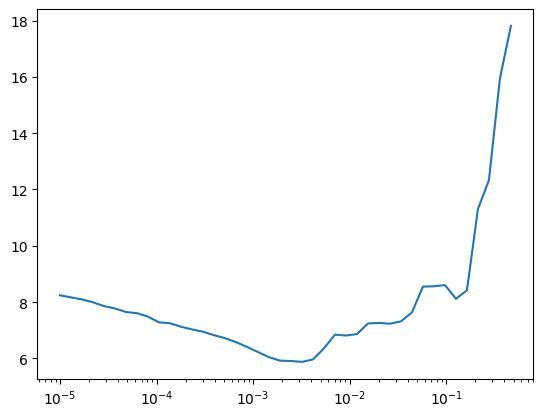

In [ ]:
opt = torch.optim.AdamW
cbs = [LLMMetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(), DeviceCB(), MixedPrecision()]
learn = Learner(model, dls, loss_func=loss_fn, cbs=cbs, opt_func=opt)
learn.lr_find()

In [ ]:
from functools import partial
from torch.optim import lr_scheduler

In [ ]:
lr, epochs = 1e-4, 2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]

GLU for ff

3000 vocab

accuracy,loss,epoch,train,time
0.247,4.280,0,train,06:22
0.371,3.050,0,eval,00:16
0.423,2.702,1,train,06:29
0.438,2.612,1,eval,00:02


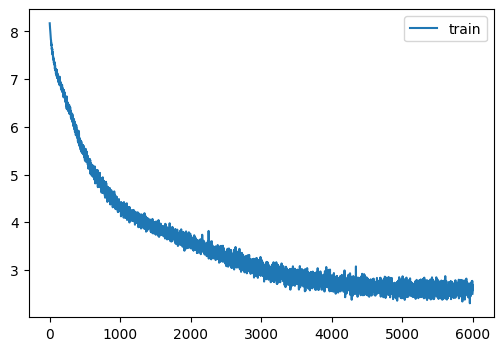

In [ ]:
set_seed(42)
model = torch.compile(GPTModel(cfg).to(def_device), mode="reduce-overhead")
cbs = [LLMMetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True), DeviceCB(), MixedPrecision()]
learn = Learner(model, dls, loss_func=loss_fn, cbs=cbs+xtra, opt_func=opt)
learn.fit(epochs, lr=lr)

In [ ]:
start_context = "Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could"
model.eval()
token_ids = generate(
    model=model.eval(),
    idx=text_to_token_ids("Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could", tokenizer).to(def_device),
    max_new_tokens=150,
    context_size=cfg["ctx_len"],
    top_k=25,
    temperature=1
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

CUDAGraph supports dynamic shapes by recording a new graph for each distinct input size. Recording too many CUDAGraphs may lead to extra overhead. We have observed 51 distinct sizes. Please consider the following options for better performance: a) padding inputs to a few fixed number of shapes; or b) set torch._inductor.config.triton.cudagraph_skip_dynamic_graphs=True. Set torch._inductor.config.triton.cudagraph_dynamic_shape_warn_limit=None to silence this warning.


Output text:
 Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could hear that everyone was a big brother. Lucy was happy to help the two were. 

After playing in the woods for a while, Lucy saw a big tree. She picked it up and ran to it with her friends. 

Suddenly as Sunny got closer, her friend, the squirrel went up to join the tree. Lucy was so happy, with her friend her the owl and they walked back to the tree again.

From that day on, Tweetie and the squirrel played with the tree with all day long.


Once upon a time, there were a little girl named Mia. Mia loved to collect things at school. One day, Mia wanted to make her family. She had a big box and she wanted to wear


Hyperparameters: Learning rate, optimizer: Gradient clipping, batch size: 4k

Mixed precision -> weight decay needed. (bfloat16)

Distributed data parallel: Split data into 2 and use graident accumulation

Fully Sharded data parallel: shard of data into GPUs as layer goes.

CPU offload

DataLoader: Use for loop.

!!!!! Look at the data. !!!!!

Eval: next token accuracy, loss

Try GLU instead of ReLU

Tips: 

1. Try simple model.
2. Weight Tying.
3. Hyperparameter sweep
4. minbpe


Get sequencing packing to work -> iterate faster
flash attention.

Use triton cross entropy loss or compile nn.crosstropyloss

Add view(-1,...) before flash attention and remove view(-1,...)